In [1]:

# Remember to login to wandb!
import sys
import os 
import torch
import matplotlib.pyplot as plt
import copy 
import numpy as np
import itertools
# Append module directory for imports
parent_dir = os.path.expanduser('../eigenestimation')
sys.path.append(parent_dir)

from toy_models.tms import AutoencoderSymmetric, GenerateTMSData, GenerateTMSDataParallel, AutoencoderParallel  # Import your model
from evaluation.networks import DrawNeuralNetwork
from eigenmodel.eigenmodel import EigenModel
from utils.loss import MSELoss
from utils.uniform_models import ZeroOutput

from toy_models.parallel_serial_network import CustomMLP
from torch import Tensor

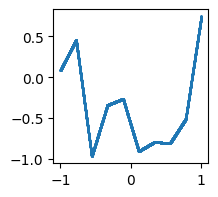

In [6]:
piecewise_data_path = "../outputs/toy_models/piecewise_training_data.pt"
piecewise_data = torch.load(piecewise_data_path)
x = np.array([x.item() for x,_ in piecewise_data])
y = np.array([y.item() for _,y in piecewise_data])
plt.figure(figsize=(2,2))
plt.plot(x,y, '.', markersize=1)

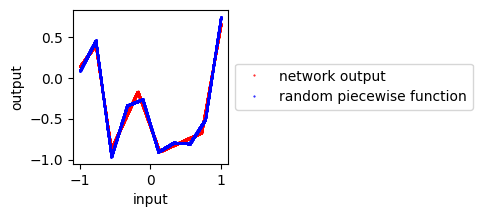

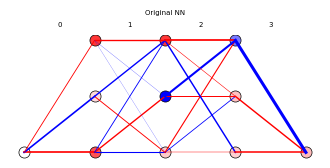

In [17]:
# Load TMS model
piecewise_model_path = "../outputs/toy_models/piecewise.pt"



piecewise_network = torch.load(piecewise_model_path)['model']

x = np.array([x.item() for x,_ in piecewise_data])
y = np.array([y.item() for _,y in piecewise_data])

y_pred = piecewise_network(Tensor([x]).transpose(0,1).to('cuda')).detach().cpu().numpy()
plt.figure(figsize=(2,2))
plt.plot(x, y_pred, 'r.', markersize=1, label='network output')
plt.plot(x,y, 'b.', markersize=1, label='random piecewise function')
# Show legend outside plot on right side
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5)) 
plt.xlabel('input')
plt.ylabel('output')
plt.show()


model_params = dict(piecewise_network.named_parameters())
weights = {k:v for k,v in model_params.items() if 'bias' not in k}
weights = {str(i):v for i,v in enumerate(weights.values())}

biases = {k:v for k,v in model_params.items() if 'bias' in k}
biases = {str(i):v for i,v in enumerate(biases.values())}

f = DrawNeuralNetwork(weights, biases, "Original NN")


/root/.eigenestimation/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


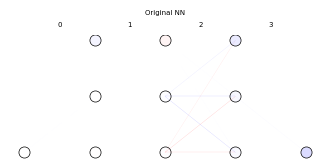

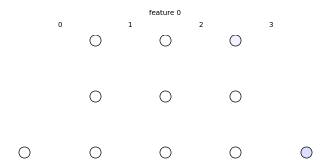

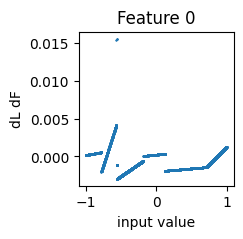

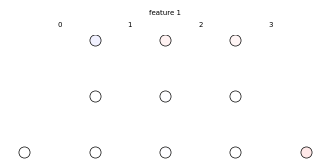

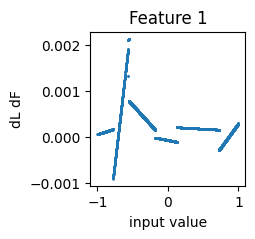

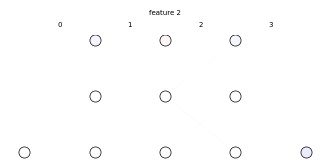

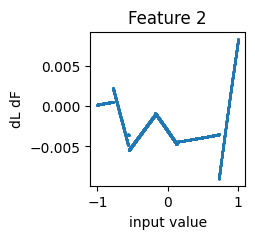

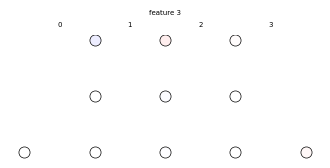

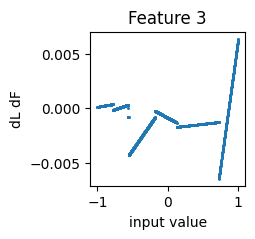

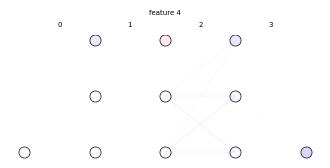

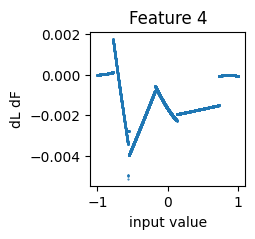

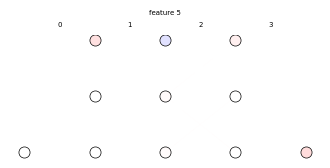

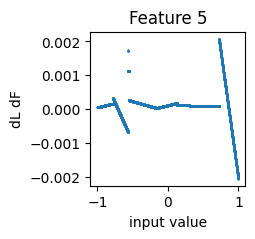

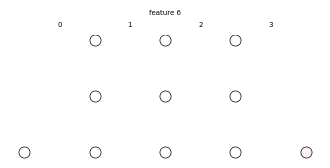

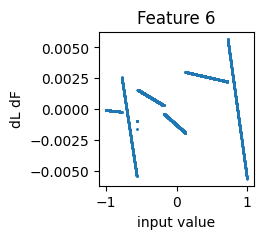

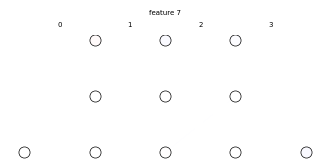

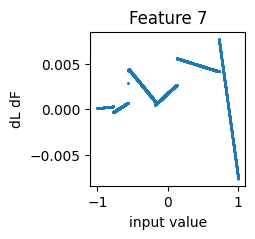

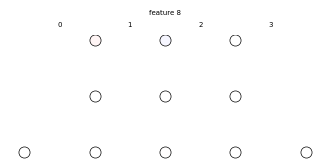

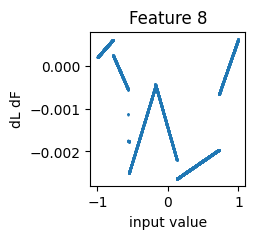

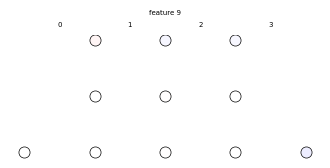

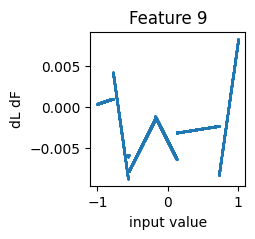

In [2]:
eigenmodel_path = "../outputs/eigenmodels/piecewise.pt"


checkpoint = torch.load(eigenmodel_path)
eigenmodel = checkpoint['model']

model_params = eigenmodel.reconstruct_network()
weights = {k:v for k,v in model_params.items() if 'bias' not in k}
weights = {str(i):v for i,v in enumerate(weights.values())}

biases = {k:v for k,v in model_params.items() if 'bias' in k}
biases = {str(i):v for i,v in enumerate(biases.values())}

f = DrawNeuralNetwork(weights, biases, "Original NN")

X = 2*torch.rand(10000,1).to('cuda')-1
feature_vals = eigenmodel(eigenmodel.compute_jacobian(X))


for i, network in enumerate(eigenmodel.construct_subnetworks()):
    
    weights = {k:v for k,v in network.items() if 'bias' not in k}
    weights = {str(i):v for i,v in enumerate(weights.values())}

    biases = {k:v for k,v in network.items() if 'bias' in k}
    biases = {str(i):v for i,v in enumerate(biases.values())}

    f = DrawNeuralNetwork(weights, biases, f"feature {i}")

    plt.figure(figsize=(2,2))
    plt.plot(X.detach().cpu().numpy(), feature_vals[:,i].detach().cpu().numpy(), '.', markersize=1)
    plt.xlabel('input value')
    plt.ylabel('dL dF')
    plt.title(f'Feature {i}')
    plt.show()


In [73]:
eigenmodel.low_rank
for i, (name, tensors) in enumerate(eigenmodel.low_rank.items()):
    if i ==0:
        sum_squares = sum([(t**2).sum(dim=list(range(len(t.shape)-1))) for t in tensors])
    else:
        sum_squares = sum_squares + sum([(t**2).sum(dim=list(range(len(t.shape)-1))) for t in tensors])

for i, (name, tensors) in enumerate(eigenmodel.low_rank.items()):
    for t in tensors:
        # Divide t by a value and keep the gradient stored
        t.data.div_(sum_squares+100)

In [65]:
t.

tensor([[[-6.2870,  1.4383, -0.6988,  1.7164, -0.5703,  1.2102,  7.3328,
          -2.8243,  0.1245, -6.8140]]], device='cuda:0',
       grad_fn=<DivBackward0>)

In [56]:
sum([(t**2).sum(dim=list(range(len(t.shape)-1))) for t in tensors])

tensor([3.4093e-08, 7.8468e-06, 1.7339e-02, 4.9321e-07, 2.0704e-02, 1.5193e-04,
        2.7574e-05, 4.2468e-06, 1.8260e-08, 6.2213e-07], device='cuda:0',
       grad_fn=<AddBackward0>)

In [48]:
tensors[1].sum(dim=list(range(1, len(tensors[1].shape))))

tensor([-0.0081], device='cuda:0', grad_fn=<SumBackward1>)

In [51]:
tensors

[tensor([[[ 4.6926e-05,  7.2303e-04, -2.7523e-02,  5.7814e-04,  5.1092e-02,
           -3.4846e-03, -2.0545e-03, -1.1891e-03,  5.5783e-05, -1.8134e-04]],
 
         [[-1.6750e-04,  2.4002e-03,  1.2777e-01,  2.5716e-04,  1.1244e-01,
            1.1715e-02, -4.2159e-03, -1.4051e-03,  6.9591e-05, -4.2745e-04]],
 
         [[ 6.1898e-05,  1.2355e-03,  1.2001e-02,  2.2204e-04,  7.3797e-02,
           -9.9725e-04, -2.3557e-03,  7.4805e-05,  1.0148e-04,  5.1657e-04]]],
        device='cuda:0', requires_grad=True),
 tensor([[[-2.2589e-06,  1.9222e-04, -1.0613e-02,  2.0865e-04,  1.8982e-03,
           -1.2429e-03,  1.7385e-04,  9.2353e-04,  2.6058e-06,  3.7374e-04]]],
        device='cuda:0', requires_grad=True)]